<img src='https://github.com/LinkedEarth/Logos/raw/master/PYLEOCLIM_logo_HORZ-01.png' width="800">

# Correlations at Sea
Correlation analysis, despite its simplicity and many shortcomings, remains a centerpiece of empirical analysis in many fields, particularly the paleosciences. Computing correlations is trivial enough; the difficulty lies in properly assessing their significance. Of particular importance are four considerations:

1. __Persistence__, which violates the standard assumption that the data are independent (which underlies the classical test of significance implemented, e.g. in Excel).
1. __Time irregularities__, for instance comparing two records with different time axes, possibly unevenly spaced (which standard software cannot deal with out of the box)
1. __Age uncertainties__, for example comparing two records, each with an ensemble of plausible chronologies (generated, for instance, by a Bayesian age model)
1. __Test multiplicity__ aka the "Look Elsewhere effect", which states that repeatedly performing the same test can result in unacceptably high type I error (accepting correlations as significant, when in fact they are not). This arises e.g. when correlating a paleoclimate record with an instrumental field, assessing significance at thounsands of grid points at once, or assessing significance within an age ensemble.

In this notebook we reproduce the study of [Hu et al, 2017](http://dx.doi.org/10.1016/j.epsl.2016.11.048), particularly the example of their section 4, which illustrates several of these pitfalls at once. The example illuminates the issue of relying too strongly on correlations between a paleoclimate record and an instrumental field to interpret the record. Before we start, a disclaimer: the studies investigated in this paper are by no means isolated cases. They just happened to be cases that we knew about, and thought deserved a second look in light of more rigorous statistics. The same study could have been written by subsituting any number of other records interpreted, wholly or in part, on the basis of correlations. Accordingly, what follows should not be viewed as an indictment of a particularly study or group of authors, rather, at how easy it is by the best-intentioned scientists to get fooled by spurious correlations. Accordingly, Pyleoclim facilitates an assessment of correlations that deals with all these cases, makes the necessary data transformations transparent to the user, and allows for one-line plot commands to visualize the results.


## Table of Contents
* [Data](#data)
* [Data Exploration](#dataexp)
    - [Crystal Cave](#crystal)
    - [Sea-surface temperature](#sst)
* [Pitfall #1: persistence](#persistence)
    - [Null models](#nulls)
    - [Timeseries alignment](#alignment)
* [Pitfall #2: look elsewhere effect](#multiple_hyp)
* [Pitfall #3: age uncertainties](#age_uncert)
* [Conclusion](#conclu)
* [References](#ref)

## <a name='data'>Data</a>

The example uses the speleothem record of [McCabe-Glynn et al. (2013)](https://www.nature.com/articles/ngeo1862) from Crystal Cave, California, in the Sequoia National Forest.  Of interest to us is the $\delta^{18}O$ record, which the authors interpret as reflecting sea-surface temperatures (SST) in the Kuroshio Extension region of the West Pacific. This is a strong claim, given that no mechanistic link is proposed,  and relies entirely on an analysis of correlations between the record and instrumental SST.  

## <a name='dataexp'>Data Exploration</a>
 We start by loading a few useful packages:

In [2]:
import matplotlib.pyplot as plt    
import pyleoclim as pyleo
pyleo.set_style('web')  # set the visual style
import numpy as np
import xarray as xr
# Note: JEG had to use this to silence warnings with xarray 0.16.1, as 0.19.1 is no longer available from conda-forge
import warnings
warnings.filterwarnings('ignore')

We now load and plot this record:

In [4]:
d = pyleo.Lipd('./data/Crystal.McCabe-Glynn.2013.lpd')
cc = d.to_LipdSeries(2)   

Disclaimer: LiPD files may be updated and modified to adhere to standards

reading: Crystal.McCabe-Glynn.2013.lpd
1.42 MB :That's a big file! This may take a while to load...
Finished read: 1 record
extracting paleoData...
extracting: Crystal.McCabe-Glynn.2013
Created time series: 3 entries


Let's do a quick plot to check that we have what we want:

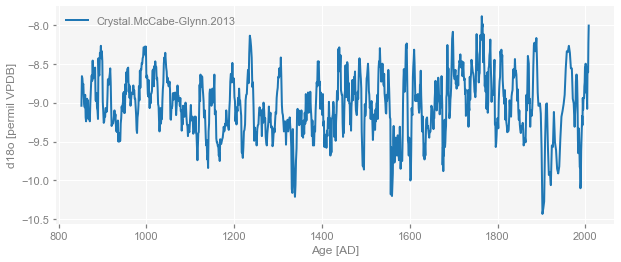

In [4]:
fig, ax = cc.plot()

Notice how the code harvested the correct metadata from the LiPD file. If everything is in its right place, it makes it easy to exploit that information. If you're feeling more frisky, you can even ask for a whole dashboard, including a spectrum:

Performing spectral analysis on individual series: 100%|█████████████████████████████████| 200/200 [00:26<00:00,  7.64it/s]


(<Figure size 792x576 with 4 Axes>,
 {'ts': <AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>,
  'dts': <AxesSubplot:xlabel='PDF'>,
  'map': <GeoAxesSubplot:>,
  'spec': <AxesSubplot:xlabel='Period [yrs]', ylabel='PSD'>})

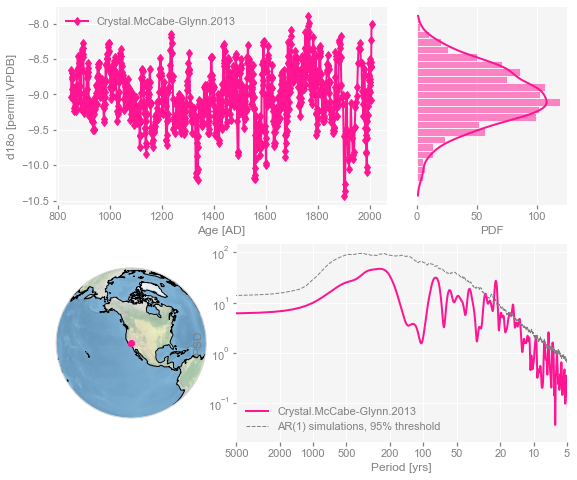

In [5]:
cc.dashboard(metadata=False)

This is a very high resolution record, with near-annual spacing (check it), and a broadly red spectrum that exhibits a number of spectral peaks at interannual and decadal scales.

### <a name='sst'>Sea-surface Temperature</a>

The original paper correlated the above record against the Kaplan SST dataset.  In this notebook we instead use the [HadSST4 dataset](https://www.metoffice.gov.uk/hadobs/hadsst4/index.html) (Morice et al, 2012),  which is more up to date, and which we first download via `wget`. (~8Mb)

In [5]:
!wget https://www.metoffice.gov.uk/hadobs/hadsst4/data/netcdf/HadSST.4.0.1.0_median.nc
!mv HadSST.4.0.1.0_median.nc ./data

--2022-06-03 12:16:38--  https://www.metoffice.gov.uk/hadobs/hadsst4/data/netcdf/HadSST.4.0.1.0_median.nc
Resolving www.metoffice.gov.uk (www.metoffice.gov.uk)... 23.45.43.110
Connecting to www.metoffice.gov.uk (www.metoffice.gov.uk)|23.45.43.110|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8772375 (8.4M) [application/x-netcdf]
Saving to: ‘HadSST.4.0.1.0_median.nc’

HadSST.4.0.1.0_medi 100%[===================>]   8.37M  3.70MB/s    in 2.3s    

2022-06-03 12:16:42 (3.70 MB/s) - ‘HadSST.4.0.1.0_median.nc’ saved [8772375/8772375]



Next we load it via the excellent `xarray` package.

In [6]:
ds = xr.open_dataset('./data/HadSST.4.0.1.0_median.nc')
print(ds)

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 36, longitude: 72, time: 2068)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-04-16
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 -177.5 -172.5 -167.5 ... 172.5 177.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 ...
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 ...
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7


As an example, let's only consider the Northern Hemisphere Pacific Ocean. For practicality, let's first adjust the coordinate system so that longitude is expressed from 0 to 360 degrees instead of 180W to 180E:

In [7]:
ds_rolled = ds.assign_coords(longitude=(ds.longitude % 360)).roll(longitude=(ds.dims['longitude'] // 2))
ds_rolled

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 36, longitude: 72, time: 2068)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-04-16
  * latitude        (latitude) float64 -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * longitude       (longitude) float64 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 nan nan nan ... nan nan
    time_bnds       (time, bnds) datetime64[ns] ...
    latitude_bnds   (latitude, bnds) float64 ...
    longitude_bnds  (longitude, bnds) float64 0.0 5.0 5.0 10.0 ... -5.0 -5.0 0.0
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

Now let's select the needed data:

In [8]:
ds_sel = ds_rolled.sel(longitude=slice(120,280),latitude=slice(0,90))
ds_sel

<xarray.Dataset>
Dimensions:         (bnds: 2, latitude: 18, longitude: 32, time: 2068)
Coordinates:
  * time            (time) datetime64[ns] 1850-01-16T12:00:00 ... 2022-04-16
  * latitude        (latitude) float64 2.5 7.5 12.5 17.5 ... 72.5 77.5 82.5 87.5
  * longitude       (longitude) float64 122.5 127.5 132.5 ... 267.5 272.5 277.5
Dimensions without coordinates: bnds
Data variables:
    tos             (time, latitude, longitude) float32 nan -0.19231786 ... nan
    time_bnds       (time, bnds) datetime64[ns] 1850-01-01 ... 2022-05-01
    latitude_bnds   (latitude, bnds) float64 0.0 5.0 5.0 10.0 ... 85.0 85.0 90.0
    longitude_bnds  (longitude, bnds) float64 120.0 125.0 125.0 ... -85.0 -80.0
Attributes:
    comment:      
    history:      Converted to netcdf today
    institution:  Met Office
    reference:    Kennedy et al. (2019), https://www.metoffice.gov.uk/hadobs/...
    source:       surface observation
    title:        Ensemble-median sea-surface temperature anomalies from the ...
    version:      HadSST.4.0.1.0
    Conventions:  CF-1.7

## <a name='persistence'> Pitfall #1: Persistence</a>

Persistence is the tendency of many geophysical timeseries (particularly in paleoclimatology) to show some kind of memory: consecutive observations tend to resemble each other, resulting in timeseries that have fairly broad trends and low-frequency fluctuations, and comparatively little high-frequency fluctuations.  This has an important consequence: the standard assumption of independence, which undergirds much of frequentist statistics, is violated in this case. In a timeseries with $n$ fully independent observations (e.g. white noise), the degrees of freedom for the variance are $DOF = n -1$  But if memory is present, this number can be drastically reduced. 

Let us look at a random location and build some intuition. First, we need to compute montly anomalies and annualize them. `xarray` makes that easy (four lines of code plus another line for plotting), so let's look at the result:

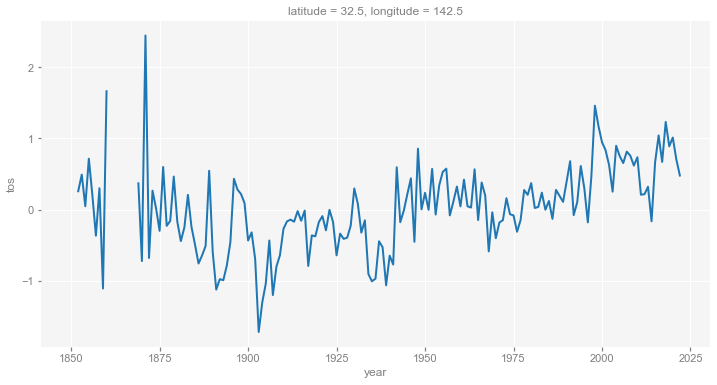

In [9]:
st = ds['tos'].sel(latitude=32.5, longitude = 142.5, method='nearest')  # 32.5N 142.5W near Kuroshio Extension
climatology = st.groupby("time.month").mean("time")
anomalies = st.groupby("time.month") - climatology
st_annual = anomalies.groupby("time.year").mean("time")
st_annual.plot(figsize=[12, 6])

Notice the coverage gaps in the 1860s. This, and the fact that the Crystal Cave chronology is not uniformly spaced, would ordinarily make it challenging to compare the two series, requiring some form of interpolation or binning. Pyleoclim does all this under the hood, provided the temperature data are turned into a _Series_ object, which is a quick operation:

In [49]:
stts = pyleo.Series(time=st_annual.coords['year'].values,
                    time_unit ='year CE', 
                    value=st_annual.values,
                    value_unit = 'C', label='HadCRUT4, 32.5N, 142.5E')

Now we can compute correlations with the Crystal Cave record. 

In [15]:
corr_res = stts.correlation(cc, seed = 2333)
print(corr_res.r)

0.32422714913422396


Quite a few things happened here. First, `pyleoclim` was smart enough to figure out a common timespan between the two records, and used linear interpolation to align the two timeseries on a common axis. Most users will be grateful not to have to do this explcitly, but the process can be customized (see [Timeseries alignment](#alignment)). 

The correlation is $r=0.324$, and the natural question is: "Is this number significant (i.e. unusual)?" The standard way to assess this is with $t$-test using the test statistic: $$T = \frac{r \sqrt{n-2}}{\sqrt{1-r^2}}$$ (see e.g. Wilks, 2011)  If we plug in the values of $r$ and $n$, we get:  

In [16]:
ccs = cc.slice([1854,2020])
n = len(ccs.time)
nu = n-2
r = corr_res.r
T  = r *np.sqrt(nu)/(np.sqrt(1-r**2))
print("The test statistic is "+ str(T))

The test statistic is 3.5947120415754927


Under standard assumptions (the data are independent and identically distributed), $T$ follows Student's $t$ distribution. If we make the same assumption and use the $t$ distribution from SciPy, we can readily compute the p-value (i.e. the probability to observe a test statistic at least as large as this one, under the null distribution):

In [19]:
from scipy.stats import t
pval = 1-t.cdf(T,nu)
print("The p-value is {:10.2e}".format(pval)) # express in exponential notation

The p-value is   2.44e-04


In other words, using the classic test for the significance of correlations "out of the box", one would conclude that SST at 42N, 164E shares so much similarity with the Crystal Cave record that there are about 2 chances in 10,000 that this could have happened randomly. In other words, it looks _rather_ significant. 

However, this test (which is the one that most computing packages, including Excel, implement by default) is not appropriate here, as the theory only applies to data that are independent and indentically distributed ("IID"). Independence means that consecutive observations have no predictive power over each other, which is true neither of the Crystal Cave nor the instrumental target. That is to say: because temperature in one year tends to resemble temperature in the previous or following year (same for $\delta^{18}O$), the data are anything but independent. We will quantify this dependence, and its consequences, below. 

The full result of the Pyleoclim `correlation()` command looks like this:

In [18]:
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.13  False



That is, the correlation value ships with an estimate of the p-value and a boolean flag (True/False) stating whether or not it is below the test level $\alpha$. However, the p-value here is estimated to be 13% (`'p': 0.13`), and therefore the correlation is not deemed significant (`'signif': False`) at the 5% level (`'alpha': 0.05`). How did `pyleoclim` arrive at such a different conclusion than the $2.4 \times 10^{-4}$ seen just above? 

### <a name='nulls'> Null Models</a>

There are in fact 3 ways to make this determination in Pyleoclim. While the standard null model for correlations in the statistical literature is the IID model, we have just seen that it is violated by the persistence of many timeseries, particularly the ones shown above.  The package does implements the classical T-test, but it is adjusted for the loss of degrees of freedom due to persistence as per Dawdy & Matalas (1964):

In [16]:
corr_ttest = stts.correlation(cc,settings={'method':'ttest'})
print(corr_ttest)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.15  False



As a result, the the p-value for the test is now 15%, far above the  $2.4 \times 10^{-4}$ it would be under the IID assumption. 

The next option compares the observed correlation to the distribution of correlations with (by default) 1000 randomly-generated autoregressive (AR(1)) timeseries with the same persistence parameters as the original series, as measured by the lag-1 autocorrelation. This model is parametric, and is named _isopersistent_ because it preserves the persistence properties of each series:

In [23]:
corr_isopersist = stts.correlation(cc,settings={'method':'isopersistent'}, seed = 2333)
print(corr_isopersist)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.12  False



Because this is a simulation-based method, the result will depent on the number of simulations, `nsim`.  Upping `nsim` ensures more consistent results, though in this case the result does not change: 

In [21]:
corr_isopersist = stts.correlation(cc,settings={'method':'isopersistent','nsim':2000}, seed = 2333)
print(corr_isopersist)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.13  False



We see that the p-value changes subtly between these two cases, but not enough to change the result (the correlation is non significant either way). However, to ensure that these sampling issues won't affect the reproducibility of the results, we specify a [random seed](https://en.wikipedia.org/wiki/Random_seed). Note that the difference between “significant” and “not significant” is not itself statistically significant (Gelman & Stern, 2006). 


The last null model method is `isospectral`, which phase-randomizes the original signals, thereby preserving the spectrum of each series but scrambling phase relations between the signals. This (non-paramettric) method was first proposed by Ebisuzaki (1997), and is called _isospectral_ because it leaves the spectrum (and therefore the autocorrelation function) intact. Since, this is also a simulation method, one can also play with the number of simulations, as done here:

In [22]:
corr_isospec = stts.correlation(cc,settings={'method':'isospectral','nsim':2000}, seed = 4343)
print(corr_isospec)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.14  False



We see that this resulted is a modestly different p-value, but again one above 5%, which leads to rejection of the test. 

In this case, the three methods concur that the correlation is insignificant, though we encourage users to play with these methods in case they obtain results close to the test-level, to discourage p-hacking temptations. 


### <a name='alignment'> Timeseries Alignment</a>

As mentioned earlier, the SST and Crystal Cave series are on different time axes, and `Pyleoclim` automated the process of aligning them, doing so under the hood so users can focus on doing science. However, it is useful to understand what is happening and how it can be customized, in case this makes a different to the analysis.  Like other `Pyleoclim` methods designed to compare timeseries,  `correlation()` relies on the `MultipleSeries.common_time()` method for alignment. The method implements three strategies for timeseries alignment:
1. interpolation
1. binning
1. Gaussian kernel smoothing (Rehfeld & Kurths, 2014)

To explore it, let us first create a `MultipleSeries` object gathering those two series:

(<Figure size 432x288 with 3 Axes>,
 {0: <Axes:ylabel='d18o [permil VPDB]'>,
  1: <Axes:ylabel='value [C]'>,
  2: <Axes:xlabel='time [year CE]'>})

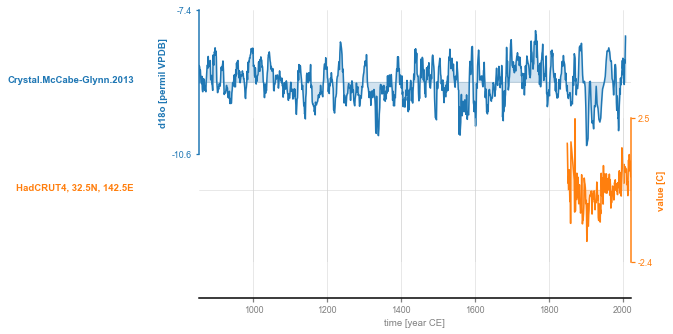

In [50]:
ms = pyleo.MultipleSeries([cc,stts])
ms.stackplot()

By default, `common_time()` will implement linear interpolation. 

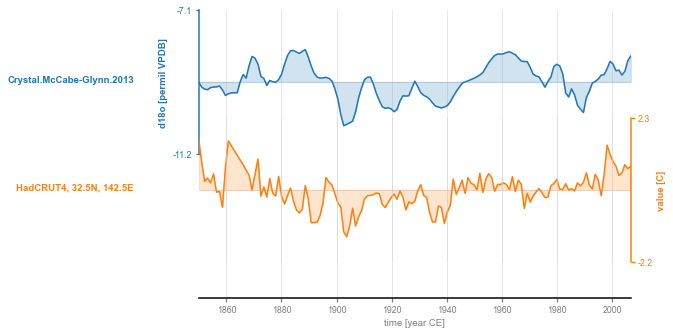

In [59]:
msi = ms.common_time()
fig, ax = msi.stackplot()

It is easy to verify that the two series are indeed on the same axis:

In [57]:
msi.series_list[0].time == msi.series_list[1].time

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,

To see how the interpolation changed the original series, we can superimpose the original series on top of this stackplot:

<Axes:ylabel='value [C]'>

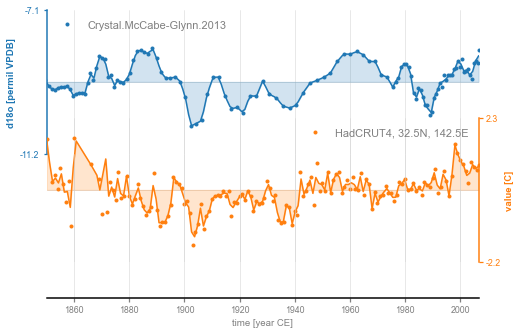

In [63]:
fig, ax = msi.stackplot(labels=None)
cc.plot(ax=ax[0],marker='.',linestyle='',xlabel='')
stts.plot(ax=ax[1],marker='.',linestyle='',color='C1',xlabel='')

We see that interpolation left the Crystal Cave record relatively unchanged, except near the end where resolution is very high. For the HadCRUT4 data, the effect is most noticeable in the 1870s, where there is a gap in data coverage. This could be customized: both the type of interpolation (e.g. linear, quadratic) and the grid step, are customizable (see the [documentation](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsutils.interp). 

As an example, we could use cubic spline interpoliation, which carries the well-known risk of overfitting, thereby creating unrealistic excursions away from observations:

<Axes:ylabel='value [C]'>

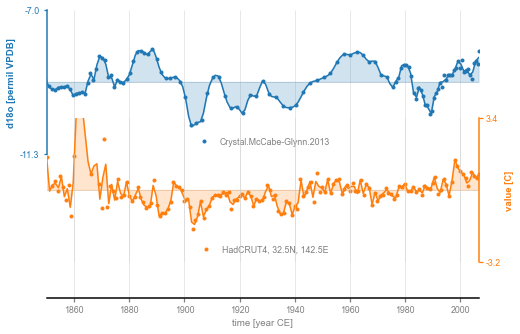

In [82]:
msi = ms.common_time(method='interp',interp_type = 'cubic')
fig, ax = msi.stackplot(labels=None)
cc.plot(ax=ax[0],marker='.',linestyle='',xlabel='')
stts.plot(ax=ax[1],marker='.',linestyle='',color='C1',xlabel='')

Another option is [binning](https://pyleoclim-util.readthedocs.io/en/latest/utils/introduction.html#pyleoclim.utils.tsutils.bin), which tends to coarse-grain more, as it will default to the largest time spacing observed in either series to avoid empty bins:

<Axes:ylabel='value [C]'>

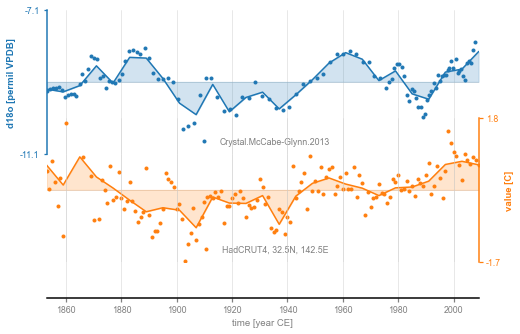

In [83]:
msb = ms.common_time(method='bin')
fig, ax = msb.stackplot(labels=None)
cc.plot(ax=ax[0],marker='.',linestyle='',xlabel='')
stts.plot(ax=ax[1],marker='.',linestyle='',color='C1',xlabel='')

Lastly, one may request a gaussian kernel, which by default uses a bandwidth of 3:

IndexError: invalid index to scalar variable.

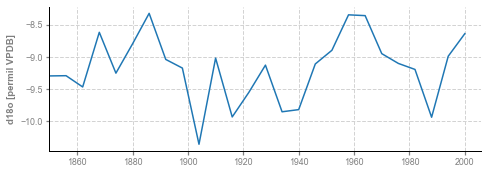

In [84]:
msg = ms.common_time(method='gkernel',h=1)
fig, ax = msg.stackplot(labels=None)
cc.plot(ax=ax[0],marker='.',linestyle='',xlabel='')
stts.plot(ax=ax[1],marker='.',linestyle='',color='C1',xlabel='')

The Gaussian kernel method is the most brittle of the three, and its results are not guaranteed. 


At the level of correlations, users may specify how they wish to perform this time alignment via the `common_time_kwargs` dictionary, like so:

In [86]:
corr_isospec = stts.correlation(cc,settings={'method':'isospectral','nsim':2000}, 
                                common_time_kwargs = {'method':'interp','interp_type':'cubic'}, seed = 4343)
print(corr_isospec)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.188206       0.36  False



We see that the type of interpolation was rather consequential here, lowering the original correlation quite a bit. For research purposes, it would be prudent to take a peak "under the hood" as we did earlier, and explore how time series alignment affects the original series. 

Note: in the case of the T-test, it would be sufficient to put the timeseries on the same time axis, but that this axis need not be evenly spaced. This is not implemented here. 

## <a name='multiple_hyp'> Pitfall #2: Multiple Hypothesis Testing</a>

The previous section shows how to properly assess significance at a single location. The situation becomes more complex as one  conducts a similar test for an entire field. To see why, let us recursively carry out the same test as above at all grid points. For this, we need not only to loop over grid points, but also store the p-values for later analysis. To save time, we'll use the `ttest` option for `correlation()`, knowing that it is rather approximate. Also, we need to exclude points that have too few observations. The loop below achieves that. 

In [88]:
nlon = len(ds_sel['longitude'])
nlat = len(ds_sel['latitude']) 
pval = np.empty((nlon,nlat)) # declare array to store pvalues
corr = np.empty_like(pval) # declare empty array of identical shape
alpha = 0.05
slon, slat = [], [];
for ji in range(nlon):
    print("Computing correlations at " + str(ds_sel.longitude[ji].values) + 'E')
    for jj in range(nlat):   
        st = ds_sel['tos'][:,jj,ji]
        climatology = st.groupby("time.month").mean("time")
        anomalies = st.groupby("time.month") - climatology
        st_annual = anomalies.groupby("time.year").mean("time")
        #  test if at least 100 non-NaNs
        noNaNs = len(np.where(np.isnan(st_annual) == False)[0]) # number of valid years
        sstvar = st_annual.var()
        if noNaNs >= 100 and sstvar >= 0.01:
            sttb = pyleo.Series(time=st_annual.coords['year'].values,
                        time_unit ='year CE', 
                        value=st_annual.values,
                        value_unit = 'C')
            corr_res = sttb.correlation(cc, settings={'method':'ttest'})
            pval[ji,jj] = corr_res.p
            corr[ji,jj] = corr_res.r
            if pval[ji,jj] < alpha:
                slon.append(ds_sel.longitude[ji])
                slat.append(ds_sel.latitude[jj])
        else:  
            pval[ji,jj] = np.nan; corr[ji,jj] = np.nan

Computing correlations at 122.5E
Computing correlations at 127.5E
Computing correlations at 132.5E
Computing correlations at 137.5E
Computing correlations at 142.5E
Computing correlations at 147.5E
Computing correlations at 152.5E
Computing correlations at 157.5E
Computing correlations at 162.5E
Computing correlations at 167.5E
Computing correlations at 172.5E
Computing correlations at 177.5E
Computing correlations at 182.5E
Computing correlations at 187.5E
Computing correlations at 192.5E
Computing correlations at 197.5E
Computing correlations at 202.5E
Computing correlations at 207.5E
Computing correlations at 212.5E
Computing correlations at 217.5E
Computing correlations at 222.5E
Computing correlations at 227.5E
Computing correlations at 232.5E
Computing correlations at 237.5E
Computing correlations at 242.5E
Computing correlations at 247.5E
Computing correlations at 252.5E
Computing correlations at 257.5E
Computing correlations at 262.5E
Computing correlations at 267.5E
Computing 

In [20]:
pvals = pval.flatten() # make the p-value array a 1D one
pvec = pvals[pvals<1] # restrict to valid probabilities as there are a few weird values.
nt = len(pvec)
print(str(nt) # check on the final number

327


We found 327 with enough data for a meaningful comparison, and 23 locations that pass the test. Where are they? To gain insight, let us plot the correlations and indicate (by shading) which are deemed significant:

Text(0.5, 1.0, 'R')

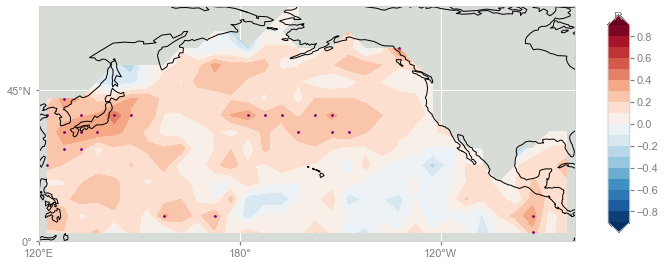

In [21]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import seaborn as sns

land_color=sns.xkcd_rgb['light grey']
ocean_color=sns.xkcd_rgb['light grey']

fig = plt.figure(figsize=[12, 8])
ax = plt.subplot(projection=ccrs.PlateCarree(central_longitude=180))

# map
ax.add_feature(cfeature.LAND, facecolor=land_color, edgecolor=land_color)
ax.add_feature(cfeature.OCEAN, facecolor=ocean_color, edgecolor=ocean_color)
ax.coastlines()

transform = ccrs.PlateCarree()
latlon_range = (120, 280, 0, 70)
lon_min, lon_max, lat_min, lat_max = latlon_range
lon_ticks = [60, 120, 180, 240, 300]
lat_ticks = [-90, -45, 0, 45, 90]

ax.set_extent(latlon_range, crs=transform)
lon_formatter = LongitudeFormatter(zero_direction_label=False)
lat_formatter = LatitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)
ax.yaxis.set_major_formatter(lat_formatter)
lon_ticks = np.array(lon_ticks)
lat_ticks = np.array(lat_ticks)
mask_lon = (lon_ticks >= lon_min) & (lon_ticks <= lon_max)
mask_lat = (lat_ticks >= lat_min) & (lat_ticks <= lat_max)
ax.set_xticks(lon_ticks[mask_lon], crs=transform)
ax.set_yticks(lat_ticks[mask_lat], crs=transform)

# contour
clevs = np.linspace(-0.9, 0.9, 19)
#corr_r, lon_r = rotate_lon(corr.T, lon)  # rotate the field to make longitude in increasing order and convert to range (0, 360)
im = ax.contourf(ds_sel.longitude, ds_sel.latitude, corr.T, clevs, transform=transform, cmap='RdBu_r', extend='both')

# significant points
plt.scatter(x=slon, y=slat, color="purple", s=3,
            alpha=1,
            transform=transform) 


# colorbar
cbar_pad = 0.05
cbar_orientation = 'vertical'
cbar_aspect = 10
cbar_fraction = 0.15
cbar_shrink = 0.5
cbar_title = 'R'
cbar = fig.colorbar(im, ax=ax, orientation=cbar_orientation, pad=cbar_pad, aspect=cbar_aspect,
                    fraction=cbar_fraction, shrink=cbar_shrink)
cbar.ax.set_title(cbar_title)

The purple dots on the map are the locations of the gridpoints where the p-values fall under 5%, and they naturally correspond to the regions of highest correlations, though (and this is suspicious) they are rather randomly scattered across the domain.  
We might be tempted to declare victory and hail them as "significant", but this is a well-known problem: the Multiple Hypothesis problem, otherwise known as the "look elsewhere" effect. 

Conducting tests at the 5% level (what most people would call "the 95% confidence level") specifically means that we expect 5% of our tests to return spurious results, just from chance alone (the so-called "type I error"). We just carried out 327 tests, so we expect $0.05*327 \approx 16 $ of those results to be false positives, right out of the gate.  So which of the 23 tests labeled as significant can we trust? One way to approach this is to rank order the p-values of all 327 tests and plot them as in Hu et al (2017), Fig 2.

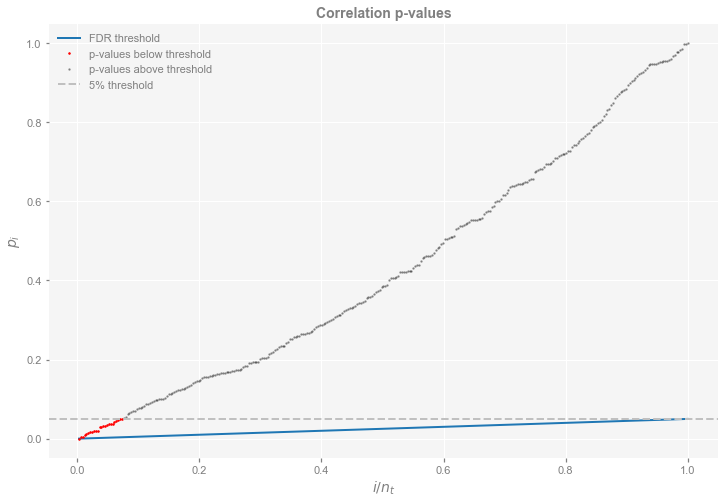

In [22]:
#check i/m vs. p-values
indexm = np.arange(1,nt+1,1)
im = 1.0*indexm / nt
thres = 0.05*im
pvec_s = sorted(pvec)
smaller=[]
small_index=[]
larger=[]
large_index=[]

n=0
for pp in pvec_s:
    if pp <=0.05:
        smaller.append(pp)
        small_index.append(im[n])
    else:
        larger.append(pp)
        large_index.append(im[n])
    n=n+1

f, ax = plt.subplots(figsize=(12,8))
plt.plot(im,thres,label='FDR threshold')
plt.plot(small_index,smaller,'ro',markersize=1.5,label='p-values below threshold')
plt.plot(large_index,larger,'ko',markersize=1.5,label='p-values above threshold',alpha=0.3)
plt.axhline(y=0.05,linestyle='dashed',color='silver',label='5% threshold')
plt.xlabel(r'$i/n_t$',fontsize=14)
plt.ylabel(r'$p_i$',fontsize=14)
plt.title('Correlation p-values',fontsize=14, fontweight='bold')
plt.legend()

One solution to this is the False Discovery Rate (aka **FDR**), which was devised in a celebrated 1995 paper [(Benjamini & Hochberg, 1995)](https://rss.onlinelibrary.wiley.com/doi/abs/10.1111/j.2517-6161.1995.tb02031.x). The idea is to look not just for the p-values under 5% (red dots in the figure above), but for the fraction of those under the blue line, which guards against the false discoveries one expects out of repeatedly testing the same hypothesis over and over again. To access this functionality in `pyleoclim` , one may do:

In [23]:
fdr_res = pyleo.utils.correlation.fdr(pvec_s)
print(fdr_res)

None


And with this treatment, exactly 0 gridpoints pass the test. 

Does this depend on our method for evaluating significance? That is easy to check:

In [91]:
pval2 = np.empty((nlon,nlat)) # declare array to store pvalues
corr2 = np.empty_like(pval) # declare empty array of identical shape
slon, slat = [], [];
sst_list = [] # initialize empty list 

for ji in range(nlon):
    print("Computing correlations at " + str(ds_sel.longitude[ji].values) + 'E')
    for jj in range(nlat):  
        st = ds_sel['tos'][:,jj,ji]
        climatology = st.groupby("time.month").mean("time")
        anomalies = st.groupby("time.month") - climatology
        st_annual = anomalies.groupby("time.year").mean("time")
        #  test if at least 100 non-NaNs
        noNaNs = len(np.where(np.isnan(st_annual) == False)[0]) # number of valid years
        sstvar = st_annual.var()
        if noNaNs >= 100 and sstvar >= 0.01:
            sttb = pyleo.Series(time=st_annual.coords['year'].values,
                        time_unit ='year CE', 
                        value=st_annual.values,
                        value_unit = 'C')
            sst_list.append(sttb) 
            corr_res = sttb.correlation(cc, settings={'method':'isospectral','nsim':1000},seed=333)
            pval2[ji,jj] = corr_res.p
            corr2[ji,jj] = corr_res.r
            if pval2[ji,jj] < alpha:
                slon.append(ds_sel.longitude[ji])
                slat.append(ds_sel.latitude[jj])
        else:  
            pval2[ji,jj] = np.nan; corr2[ji,jj] = np.nan

Computing correlations at 122.5E
Computing correlations at 127.5E
Computing correlations at 132.5E
Computing correlations at 137.5E
Computing correlations at 142.5E
Computing correlations at 147.5E
Computing correlations at 152.5E
Computing correlations at 157.5E
Computing correlations at 162.5E
Computing correlations at 167.5E
Computing correlations at 172.5E
Computing correlations at 177.5E
Computing correlations at 182.5E
Computing correlations at 187.5E
Computing correlations at 192.5E
Computing correlations at 197.5E
Computing correlations at 202.5E
Computing correlations at 207.5E
Computing correlations at 212.5E
Computing correlations at 217.5E
Computing correlations at 222.5E
Computing correlations at 227.5E
Computing correlations at 232.5E
Computing correlations at 237.5E
Computing correlations at 242.5E
Computing correlations at 247.5E
Computing correlations at 252.5E
Computing correlations at 257.5E
Computing correlations at 262.5E
Computing correlations at 267.5E
Computing 

In [92]:
pvals2 = pval2.flatten() # make the p-value array a 1D one
pvec2 = pvals2[pvals2<1] # restrict to valid probabilities as there are a few weird values.
fdr_res2 = pyleo.utils.correlation.fdr(sorted(pvec2))
print(fdr_res2)

[0]


Here 1 grid point emerges as significant with this method. Now, another way we could have done this is to bundle all SST series from each grid point as a MultipleSeries object, and let the `CorrEns` class do its magic. This allows to directly compute the correlation between objects, and leverage the [CorrEns class](https://pyleoclim-util.readthedocs.io/en/latest/core/api.html#correns-pyleoclim-correns) and its plotting method:

Looping over 327 Series in collection


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 327/327 [00:31<00:00, 10.46it/s]


(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

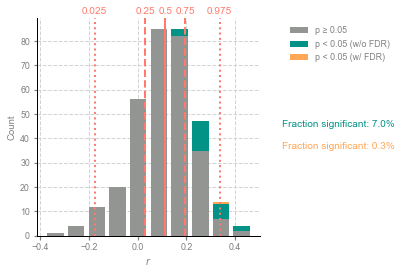

In [93]:
sstMS = pyleo.MultipleSeries(sst_list)
corr_ens = sstMS.correlation(cc,settings={'method':'isospectral','nsim':1000},seed=333)   
corr_ens.plot()

In [94]:
corr_ens.signif_fdr.count(True)

1

We find the same result as before, though in a much more compact form. Note, however, that this method does not keep track of where the significant points are (it does not have a notion of what "where" means), so if you wanted to draw a map like the one above, you would be better off with the loop shown above. 

## <a name='age_uncert'> Pitfall #3: Age uncertainties </a>

The first two pitfalls notwithstanding, there is a third difficulty in this comparison: beautiful though U/Th chronologies may be, they harbor uncertainties too, and such chronological uncertainties must be taken into account.  The LiPD file provided with this notebook contains not only the raw U/Th dates and the published ages, but also an ensemble of age-depth relationships derived from those dates, via the Bayesian age model [BChron](https://cran.r-project.org/web/packages/Bchron/vignettes/Bchron.html) (Haslett & Parnell, 2008). Let us load those 1000 draws from the posterior distribution of ages and put them in a place where `pyleoclim` will be able to work with them:

In [95]:
cc_ens = cc.chronEnsembleToPaleo(d)

The resulting object is an `EnsembleSeries`, a special case of `MultipleSeries` where all constituent series have the same units There are two ways to plot this ensemble. First, as a series of traces:

<AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>

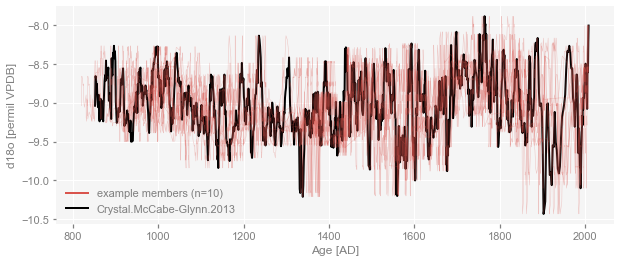

In [97]:
pyleo.set_style('web')  # set the visual style
fig, ax = cc_ens.plot_traces()
cc.plot(color='black', ax = ax)

It is quite plain that any of the record's main swings can be swung back and forth by up to decades. Another way to see this is to plot various quantiles as an envelope:

<AxesSubplot:xlabel='Age [AD]', ylabel='d18o [permil VPDB]'>

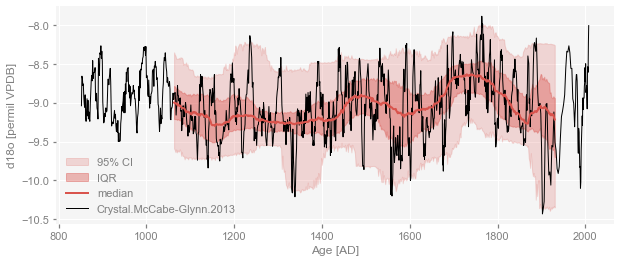

In [98]:
fig, ax = cc_ens.common_time(method='interp').plot_envelope(ylabel = cc.value_name)
cc.plot(color='black', ax = ax, linewidth=1)

Notice how the quantiles are computed over only part of the interval covered by the original series; that is because some age models end up being more compressed or stretched out than the original, and we need a common interval to compute quantiles. In particular, notice how the base of the record could really be anywhere between 850 and 1100 AD. Now, what we'd like to do is repeat the exercise of Part 1, correlating the same SST timeseries from 32.5N 142.5W (near the Kuroshio Extension), not just with the published chronology, but this whole ensemble. Remember how we had computed things:

In [102]:
corr_res = stts.correlation(cc, seed = 22)
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.14  False



Though of course, we could have done just the reverse, as correlation is a symmetric operator:

In [103]:
corr_res = cc.correlation(stts, seed = 22)
print(corr_res)

  correlation    p-value  signif. (α: 0.05)
-------------  ---------  -------------------
     0.324227       0.15  False



Now, consider the task ahead: a user must iterate over all ensemble members, taking care of aligning their time axis to that of HadSST4; you must compute the correlation and establish its significance with a sensible test (Pitfall #1), watching out for test multiplicity (see Pitfall #2) _and_  visualizing the results in an intuitive way. `pyleoclim` simplifies this process, which illustrate here for the Kuroshio Extension location as above.  To keep computing time manageable, we reduce the number of isospectral simulations to 500, and correlate the ensemble and the SST series we started with:

In [106]:
corr_Kuroshio = cc_ens.correlation(stts,settings={'nsim':500},seed = 453) 

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:54<00:00, 18.38it/s]


Again `corr_Kuroshio` is a `CorrEns` object, which contains everything you want: the vector of correlations, the p-values, _and_ a method to plot them all:

(<Figure size 288x288 with 1 Axes>, <AxesSubplot:xlabel='$r$', ylabel='Count'>)

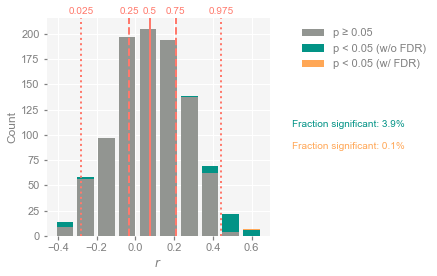

In [39]:
corr_Kuroshio.plot()

Several things jump out at once:
1. the correlation histogram is relatively symmetric, meaning that age uncertainties are able to completely overturn the original correlation of about 0.31 : nearly half of the ensemble exhibits negative correlations with SST).  0.31 (9% of common variance) is not a contender for winning the correlation olympics, but it was at least positive. Age uncertainties can easily reverse even the sign of that correlation.
1. As shown in teal, only ~4\% of the 500*100 correlations just computed are judged significant. 
1. Once we take test multiplicity into account via the False Discovery Rate (orange bar), only a fraction of a \%  is deemed significant. 

## <a name='conclu'> Conclusion </a>

In conclusion, we see, as in Hu et al (2017), that all of these pitfalls matter. Any single of them can turn a correlation initially reported as significant into an insignificant one, and these pitfalls compound one another. The conjunction of all 3 pitfalls (persistence, test multiplicity, and age uncertainties) is particularly damaging in this example, invalidating the published interpretation of Crystal Cave $\delta^{18}O$ as a proxy for Kuroshio Extension SST. 

Pyleoclim makes it easy to deal with those pitfalls, which is hoped to help avoid spurious correlations in paleoclimatology and paleoceanography. It bears emphasizing, as Hu et al (2017) did, that a significant linear correlation is neither necessary nor sufficient a condition to establish the interpretation of a proxy series, and that mechanistic models or _in situ_ monitoring are generally needed.   

## <a name='ref'> References </a>

Benjamini, Y., and Y. Hochberg (1995), Controlling the false discovery rate: A practical and powerful approach to multiple testing, Journal of the Royal Statistical Society. Series B (Methodological), 57(1), 289–300, doi:10.2307/2346101.

Dawdy, D., and N. Matalas (1964), Statistical and probability analysis of hydro- logic data, part III: Analysis of variance, covariance and time series, McGraw-Hill.

Ebisuzaki, W. (1997), A method to estimate the statistical significance of a correlation when the data are serially correlated, Journal of Climate, 10(9), 2147–2153, doi:10.1175/1520- 0442(1997)010¡2147:AMTETS¿2.0.CO;2

Gelman, A., and H. Stern (2006), The difference between “significant” and “not significant” is not itself statistically significant, The American Statistician, 60(4), 328–331, doi: 10.1198/000313006X152649.

Haslett, J., and A. Parnell (2008), A simple monotone process with application to radiocarbon-dated depth chronologies, Journal of the Royal Statistical Society: Series C (Applied Statistics), 57(4), 399–418, doi:10.1111/j.1467-9876.2008.00623.x.

Hu, J., J. Emile-Geay, and J. Partin (2017), Correlation-based interpretations of paleoclimate data – where statistics meet past climates, Earth and Planetary Science Letters, 459, 362–371, doi:10.1016/j.epsl.2016.11.048

McCabe-Glynn, S., K. R. Johnson, C. Strong, M. Berkelhammer, A. Sinha, H. Cheng, and R. L. Edwards (2013), Variable North Pacific influence on drought in southwestern North America since AD 854, Nat. Geosci., 6(8), 617–621, doi:10.1038/NGEO1862.

Morice, C. P., J. J. Kennedy, N. A. Rayner, and P. D. Jones (2012), Quantifying uncertainties in global and regional temperature change using an ensemble of observational estimates: The HadCRUT4 data set, Journal of Geophysical Research: Atmospheres, 117(D8), n/a–n/a, doi:10.1029/2011JD017187.

Rehfeld, K., and J. Kurths (2014), Similarity estimators for irregular and age-uncertain time series, Climate of the Past, 10(1), 107–122, doi:10.5194/cp-10-107-2014

Wilks, D. S. (2011), Statistical Methods in the Atmospheric Sciences: an Introduction, 676 pp., Academic Press, San Diego
